In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

In [3]:
# imports
# I was trying a lot of different things during this notebook therefore there might be the one or two libaries which
# arn´t needed anymore


import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter 

import datetime as dt
from datetime import date
from scipy import stats
#from pandas.core import datetools
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
import warnings
import seaborn as sns


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from sklearn import preprocessing


import json
from time import sleep
from datetime import datetime

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix # confusion matrix
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import gc

In [2]:
from pylab import rcParams

rcParams['figure.figsize'] = 30, 30
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

%matplotlib inline

warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

### Notebook Part 1
#### 1. Datacleaning
##### 2. EDA

Introduction to the first part of the Assignment 2 in Applied Machine Learning:
First of all we have to say, that the biggest problem we had with our Machines.
Our Laptops were not used to deal with such a Big Data so a big part of our work in this assignment was to get the most efficient dataset out of the original one. 
Therefore we created a strategy to reduce step by step memory usage without deleting important information for our algorithms.

Thats why we were starting with a strong filter to clean our data. We just delete constant data with std. deviation of 0.
So just the data with no benefit for our dataset.
Then we will run the Random Forest over the dataset to get form the algorithm the features which have no information gain.
And so on, you will see the individual steps below...

In the end we will present a small EDA for the target value and our best 10 features.
We focused just on the target and 10 features because of the anonymized data we have no clue what the features are about.
SO we just wanted to see the distribution and values of the target and the correlation of our features in order to find the right algorithms.

##### Reading in our hole datasets

In [3]:
train = pd.read_csv('..\datasets/st1_train.csv') # Source: Kaggle
test = pd.read_csv('..\datasets/st_test.csv') # Source: Kaggle

We had some trys with transforming the data to sparse, had a huge saving of memory usage but also was not efficient when it comes to algorithm implementation. But with huge datasets it might be a good aproach. We will also apply it later in a final stage of reduction.

In [4]:
# source: https://www.kaggle.com/asydorchuk/save-98-of-ram
#just doing it for test, train we cant adjust now, because of the transformation to NAN, would destroy our Feature engineering
#test = test.replace(0, np.nan).to_sparse()

### Small EDA

Here just some small outputs to get a feeling....

In [5]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


The test dataset uses a lot of memory, so we have to reduce the memory a lot in order to perform our algorithms.
In our first trys with the whole dataset we had to interrupt the process due to the long time running. (A whole night was not enough with the XG Boost)

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


The Dataframe has no missing values, thats a good sign, but seems to have huge amount of null values

In [7]:
# looking for empty values
missing= train.isna().sum()
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False).round(2)
missing_data =pd.DataFrame([missing, percent], index = ['missing', 'percent'])
missing_percent=missing_data.transpose()
missing_percent

,missing,percent
ID,0.0,0.0
target,0.0,0.0
48df886f9,0.0,0.0
0deb4b6a8,0.0,0.0
34b15f335,0.0,0.0
...,...,...
71b203550,0.0,0.0
137efaa80,0.0,0.0
fb36b89d9,0.0,0.0
7e293fbaf,0.0,0.0


In [8]:
train = train.set_index('ID')

### 1. Data Cleaning

#### 1.1 Filter out constant values
First we wanna filter out constant values, they dont bring any value to our algorithm.
Tool: Using Standard Deviation

In [9]:
#Remove constant values, not changing values...

# check and remove constant columns
colsToRemove = []
for col in train.columns:
    if col != 'ID' and col != 'target':
        if train[col].std() == 0 or train[col].mean() == 0: 
            colsToRemove.append(col)
        
# remove constant columns in the training set
train.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
test.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `256` Constant Columns

['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a7

256 had a standard deviation of 0, so all the values in this features had to be the same in every row

In [10]:
train.head()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
ID,,,,,,,,,,,,,,,,,,,,,
000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


#### 1.2 First Feature Selection with Random Forest

Random Forest can't work with continious labels, so we use the label encoder due to our algorithm can work for the feature importance

In [11]:
# here we are safing our dataset, because label Encoder was changing our train dataset
original = train.copy()


In [12]:
train_RM = train

In [13]:
train_RM.head()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
ID,,,,,,,,,,,,,,,,,,,,,
000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


Random Forest was complaining about float formats, so we use the encoder to perform RM

In [14]:
for f in train_RM.columns:
    if f != 'traget':
        if train_RM[f].dtype=='float': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_RM[f].values))
            train_RM[f] = lbl.transform(list(train_RM[f].values))

Now we can apply our Classification Algorithm Random Forest to get Features they are unnecessary. 
We therefore want to filter the features with no value for the Random Forest.
##### The Random Forest Score is builded this way:

By training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure.

In [2]:
#changing it back to the original version and drop original due to memory usage reduction
train = original

del original
train.head()

Building the classifier and build feature importance after fitting

In [16]:
clf = RandomForestClassifier()
x = train_RM.drop('target', axis=1)
X = x
y = train_RM.target

#feature selection
#When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. 
#For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure.

clf.fit(X,y)

rank = pd.DataFrame(clf.feature_importances_,index= X.columns)
rank.columns = ['Random Forest Score']
rank.sort_values(by = 'Random Forest Score' , ascending = False)


,Random Forest Score
f190486d6,0.003911
9fd594eec,0.003592
58e2e02e6,0.003530
6eef030c1,0.003445
15ace8c9f,0.002812
...,...
f06ce77ec,0.000000
118930f35,0.000000
e816e534f,0.000000
a8c7f5c13,0.000000


Building the DF zero to get a DF with features that have no importance for the classification.
Like explained above, features with value 0 had no impact on impurity decrease

In [17]:
del train_RM #to waste no Memory we delete the df after we used it
rank.rename(columns={'Random Forest Score': 'RM_score'}, inplace=True)
zero = rank[rank.RM_score == 0]
zero

,RM_score
0deb4b6a8,0.0
a8cb14b00,0.0
2f0771a37,0.0
30347e683,0.0
d08d1fbe3,0.0
...,...
8f55955dc,0.0
5ca0b9b0c,0.0
2e84e09c5,0.0
f677d4d13,0.0


In [18]:
print('After running the Random Forest we are deleting {} features'.format(len(zero)))

After running the Random Forest we are deleting 1084 features


Note: Due to the fact that random forest is using randomly the features, the selection is sometimes different, but over all the same bad features are picked.

In [19]:
train.drop(zero.index, axis = 1, inplace = True)

In [20]:
test.drop(zero.index, axis = 1, inplace = True)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4459 entries, 000d6aaf2 to ffeb15d25
Columns: 3652 entries, target to 9fc776466
dtypes: float64(1776), int64(1876)
memory usage: 124.3+ MB


Always checking if train and test DF having the same shape (column)

In [22]:
train.shape

(4459, 3652)

In [23]:
test.shape

(49342, 3652)

#### 1.3 Reducing via Data Type adjustments

In [24]:
#source= https://wkirgsn.github.io/2018/02/10/auto-downsizing-dtypes/
from joblib import Parallel, delayed
import gc

#__AUTHOR__ = 'Kirgsn'

class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe to in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        """
        if conv_table is None:
            self.conversion_table = \
                {'int': [np.int8, np.int16, np.int32, np.int64],
                 'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                 'float': [np.float16, np.float32, ]}
        else:
            self.conversion_table = conv_table
            
        #gc.collect()

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=-1, max_nbytes=None)(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)

        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):

        # skip NaNs
        if s.isnull().any():
            if verbose:
                print(colname, 'has NaNs - Skip..')
            return s

        # detect kind of type
        coltype = s.dtype
        if np.issubdtype(coltype, np.integer):
            conv_key = 'int' if s.min() < 0 else 'uint'
        elif np.issubdtype(coltype, np.floating):
            conv_key = 'float'
        else:
            if verbose:
                print(colname, 'is', coltype, '- Skip..')
            print(colname, 'is', coltype, '- Skip..')
            return s

        # find right candidate
        for cand, cand_info in self._type_candidates(conv_key):
            if s.max() <= cand_info.max and s.min() >= cand_info.min:

                if verbose:
                    print('convert', colname, 'to', str(cand))
                return s.astype(cand)

        # reaching this code is bad. Probably there are inf, or other high numbs
        print(("WARNING: {} " 
               "doesn't fit the grid with \nmax: {} "
               "and \nmin: {}").format(colname, s.max(), s.min()))
        print('Dropping it..')

In [25]:
reducer = Reducer()
data_test = reducer.reduce(test)

In [26]:
data_test = data_test.set_index('ID')

In [27]:
reducer = Reducer()
data_train = reducer.reduce(train)

#### 1.4 Next Filter by kicking null data
- by kicking data with more then 90% data = 0
- & very constant values

In [28]:
#del test_identity, test_transaction, train_identity, train_transaction


gc.collect()

one_value_cols = [col for col in data_train.columns if data_train[col].nunique() <= 1]
one_value_cols_test = [col for col in data_test.columns if data_test[col].nunique() <= 1]

many_null_cols = [col for col in data_train.columns if data_train[col].isnull().sum() / data_train.shape[0] > 0.9]
many_null_cols_test = [col for col in data_test.columns if data_test[col].isnull().sum() / data_test.shape[0] > 0.9]

big_top_value_cols = [col for col in data_train.columns if data_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.999]
big_top_value_cols_test = [col for col in data_test.columns if data_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.999]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
#cols_to_drop.remove('target')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))
# adding part of whole dataset
part = (len(cols_to_drop)/(len(data_train.columns)+len(data_test.columns))*100)
print('Thats {} % of the whole dataset '.format(round(part, 2)))

167 features are going to be dropped for being useless
Thats 2.29 % of the whole dataset 


In [29]:
data_train = data_train.drop(cols_to_drop, axis=1)
data_test = data_test.drop(cols_to_drop, axis=1)

And checking again, same shape?

In [30]:
data_train.shape

(4459, 3485)

In [31]:
data_test.shape

(49342, 3484)

#### 1.5. Further Cleaning through Feature Selection from the Light GBM

Now we want to use a further Feature Selection.
Light GBM is much faster with large data then other Boosting algorithms, thats why we are using Light GBM in the first step to select important features to safe time with the other Boosting algorithms.
We got some parts from: https://www.kaggle.com/samratp/lightgbm-xgboost-catboost

In [32]:
x = data_train.drop('target', axis=1)
X_train = x
y_train = data_train.target
X_test = data_test

In [33]:
dev_X, val_X, dev_y, val_y = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [34]:
def run_lgb(train_X, train_y, val_X, val_y, X_test):    #test_X zu X_test geändert
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, #5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=50, 
                      #verbose_eval=150, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) #test_X zu X_test geändert
    return pred_test_y, model, evals_result
    return  model

In [35]:
# Training LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

[1]	training's rmse: 8.38737e+06	valid_1's rmse: 7.53665e+06
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 8.37686e+06	valid_1's rmse: 7.53057e+06
[3]	training's rmse: 8.36633e+06	valid_1's rmse: 7.52311e+06
[4]	training's rmse: 8.3558e+06	valid_1's rmse: 7.51682e+06
[5]	training's rmse: 8.34493e+06	valid_1's rmse: 7.50985e+06
[6]	training's rmse: 8.33423e+06	valid_1's rmse: 7.50332e+06
[7]	training's rmse: 8.3246e+06	valid_1's rmse: 7.49795e+06
[8]	training's rmse: 8.31429e+06	valid_1's rmse: 7.4912e+06
[9]	training's rmse: 8.30411e+06	valid_1's rmse: 7.48498e+06
[10]	training's rmse: 8.29354e+06	valid_1's rmse: 7.47846e+06
[11]	training's rmse: 8.2831e+06	valid_1's rmse: 7.47127e+06
[12]	training's rmse: 8.27277e+06	valid_1's rmse: 7.4637e+06
[13]	training's rmse: 8.26229e+06	valid_1's rmse: 7.45741e+06
[14]	training's rmse: 8.25247e+06	valid_1's rmse: 7.45222e+06
[15]	training's rmse: 8.24232e+06	valid_1's rmse: 7.44491e+06
[16]	training's rmse: 8

In [36]:
# feature importance
#If "split", result contains numbers of times the feature is used in a model.
#    If "gain", result contains total gains of splits which use the feature.

print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)

Features Importance...


Similar to the selection with Random Forest, we create a DF with the 0 values, so the features which had no impact on the Light GBM in the training and drop them from the dataset.

In [37]:
zero_LGB = featureimp[featureimp.split == 0]

In [38]:
zero_LGB

,feature,split,gain
2303,b5c4708ad,0,0.0
2311,ed1d5d137,0,0.0
2357,1ea08665c,0,0.0
2306,2e762ec53,0,0.0
2308,8768af50f,0,0.0
...,...,...,...
1230,9c502dcd9,0,0.0
1231,b1c5346c4,0,0.0
1232,823ac378c,0,0.0
1233,134ac90df,0,0.0


In [40]:
original_train = data_train
original_test = data_test

In [42]:
t = data_train
z= data_test

Now we will drop the list from our Dataframe to get a reduced DF

In [43]:
t.drop(zero_LGB.feature, axis = 1, inplace = True)

In [44]:
z.drop(zero_LGB.feature, axis = 1, inplace = True)

Final Check wheather test and train DF have the same shape:

In [45]:
z.shape

(49342, 429)

In [46]:
t.shape

(4459, 430)

#### 1.6 Sparse 
We also want to try sparse as dtype for NAN vaues.
With this function you can achieve a vital memory usage reduction.
After a long research we figured that its on the one hand less memory usage, but on the other hand it can reduce accurancy by Boosting the data. Therefore we save both DFs and check in the prediction the differences.

In [47]:
z.to_csv('test_adj_complete_featureselection.csv')
t.to_csv('train_adj_complete_featureselection.csv')

In [48]:
# source: https://www.kaggle.com/asydorchuk/save-98-of-ram
test_df_sparse = z.replace(0, np.nan).to_sparse()
train_df_sparse = t.replace(0, np.nan).to_sparse()

Let check the difference in memory usage

In [49]:
train_df_sparse.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Index: 4459 entries, 000d6aaf2 to ffeb15d25
Columns: 430 entries, target to 3a13ed79a
dtypes: Sparse[float32, nan](375), Sparse[float64, nan](55)
memory usage: 2.8+ MB


In [51]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4459 entries, 000d6aaf2 to ffeb15d25
Columns: 430 entries, target to 3a13ed79a
dtypes: float32(375), uint32(55)
memory usage: 7.5+ MB


In [53]:
test_df_sparse.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Index: 49342 entries, 000137c73 to fffbe2f6f
Columns: 429 entries, 20aa07010 to 3a13ed79a
dtypes: Sparse[float32, nan](429)
memory usage: 12.0+ MB


In [54]:
z.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49342 entries, 000137c73 to fffbe2f6f
Columns: 429 entries, 20aa07010 to 3a13ed79a
dtypes: float32(429)
memory usage: 81.1+ MB


Result: After the whole reduction we even can reduce the memory usage about more then the half by using sparse.
our 
- train dataset has now 7.5 MB without sparse and 2.8 MB with sparse.
- test dataset has now 81 MB without sparse and 12 MB with sparse.

started by 1.8 GB of memory usage in the test dataset.



In [55]:
#lets safe the data 
test_df_sparse.to_csv('test_adj_complete_featureselection_sparse.csv')
train_df_sparse.to_csv('train_adj_complete_featureselection_sparse.csv')

### 2. EDA and Visualisations

In [4]:
train = pd.read_csv('train_adj_complete_featureselection.csv', index_col= 'ID') # Source: Kaggle
test = pd.read_csv('test_adj_complete_featureselection.csv', index_col= 'ID') # Source: Kaggle

#### 2.1 Target Illustration

Lets get a good fealing what our tagret is about:

In [17]:
train.target.mean()

5944923.32246019

In [14]:
train.target.median()

2260000.0

In [13]:
train.target.max()

40000000.0

In [18]:
train.target.min()

30000.0

Best way to illustrate the distribution of our target value is the Histogram.
We used some fancy style to pimp them a little bit up.

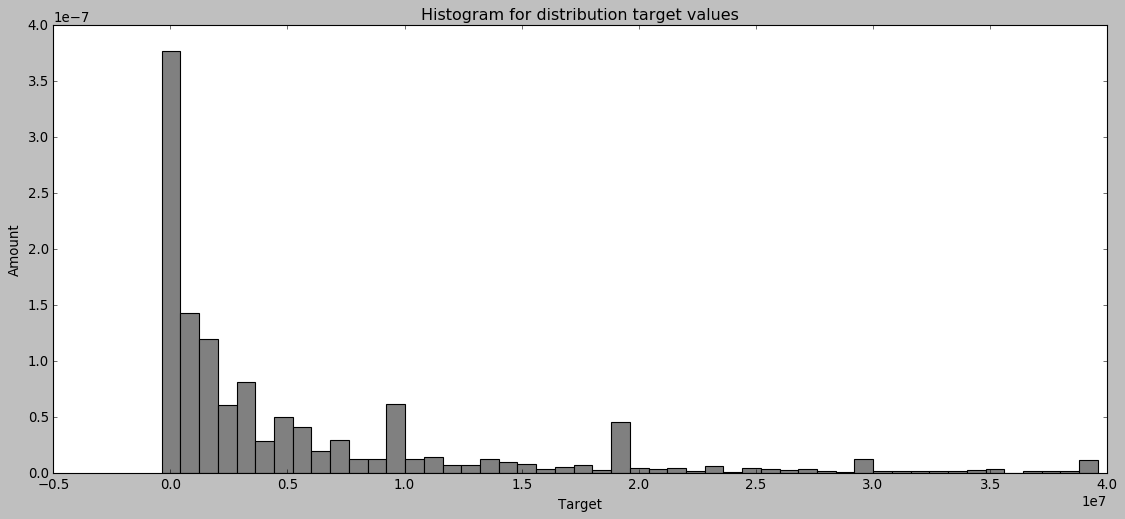

In [10]:
#all palettes: https://matplotlib.org/tutorials/introductory/customizing.html
with plt.style.context('classic'):
    plt.figure(figsize=(17, 7))
    plt.hist(train.target.values, bins=50, density = True, 
         histtype = 'barstacked', align = 'left', orientation = 'vertical',
        log = False, color = 'grey')
    plt.title('Histogram for distribution target values')
    plt.xlabel('Target')
    plt.ylabel('Amount')
plt.show()

Interpretation: This graphic shows the we have many small values as targets around the min value of 30.000. But also some very big values with 40. Million. Lets see some other graphs:

Next plot shows a cumulation of the values. This graph supports the analysis from the first graph that the counts of numbers acts versus exponential, so the increase decreases the more we will come to higher values...

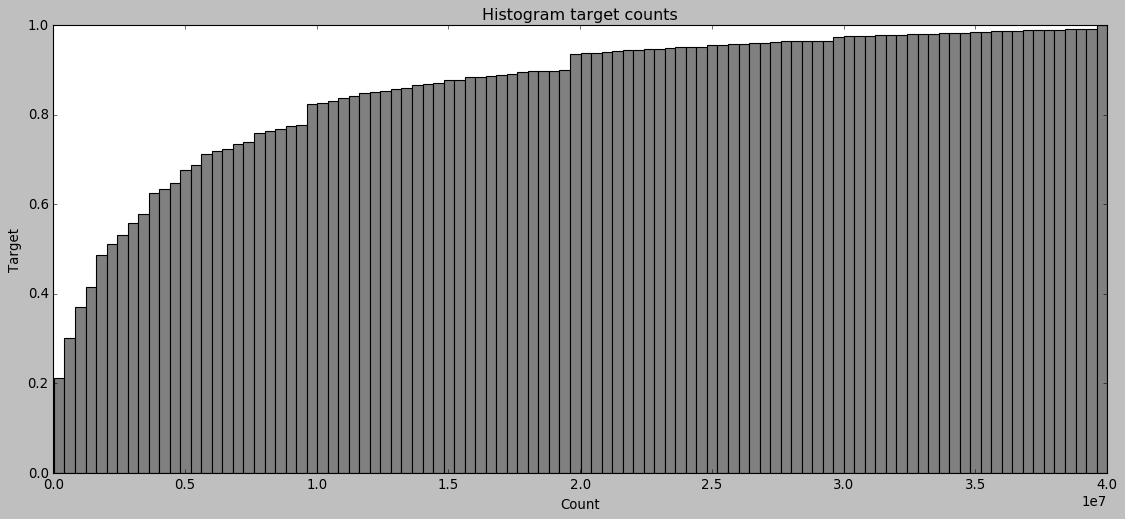

In [11]:
with plt.style.context('classic'):
    plt.figure(figsize=(17, 7))
    plt.hist(train.target.values, bins=100, density = True, cumulative = True, color = 'grey')
    plt.title('Histogram target counts')
    plt.xlabel('Count')
    plt.ylabel('Target')
plt.show()

The next graph should also give us a trendline of the distribution:

C:\Users\Tobias\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



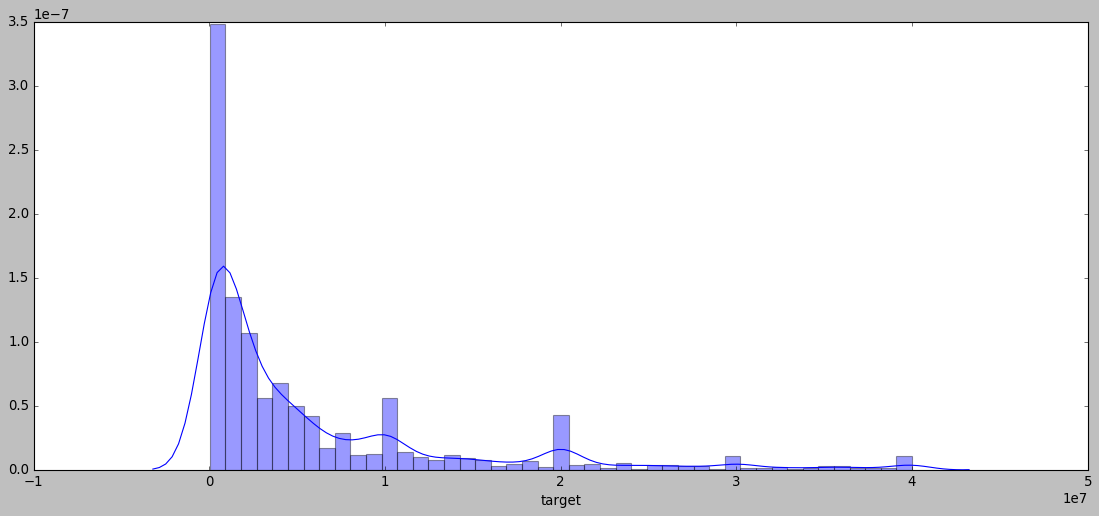

In [12]:
with plt.style.context('classic'):
    plt.figure(figsize=(17, 7))
    sns.distplot(train["target"])
plt.show()

Illustrated is a right tailed graph. Thats also good to understand when the median of of around 2 Million is compared to the mean of almost 6 million is compared. That fact underlines exactly the picture we see above. Many values under 100 thousand but the large numbers from 20 to 40 Million increases the mean value a lot. Therefore the median should be a better measure for the average values. 

We figured also the interesting fact, that investors are spending money in round values. There is always a peak in the histogram when a whole number is standing. So by 10, 20, 30 ans 40 Million.

#### 2.2 Top 10 Feature Selection

Now we are using the dataset of the feature selection of Random Forest with the top 10 features and try some correlation and other visualisations.

In [27]:
rank.iloc[:10].index

Index(['20aa07010', '77c9823f2', '0d866c3d7', '22ed6dba3', '87ffda550',
       '822e49b95', 'd04e16aed', '251d1aa17', '963a49cdc', '7b58c8e37'],
      dtype='object')

In [43]:
plt_df = train[['target', '20aa07010', '77c9823f2', '0d866c3d7', '22ed6dba3', '87ffda550', '822e49b95', 'd04e16aed', '251d1aa17', '963a49cdc', '7b58c8e37']]

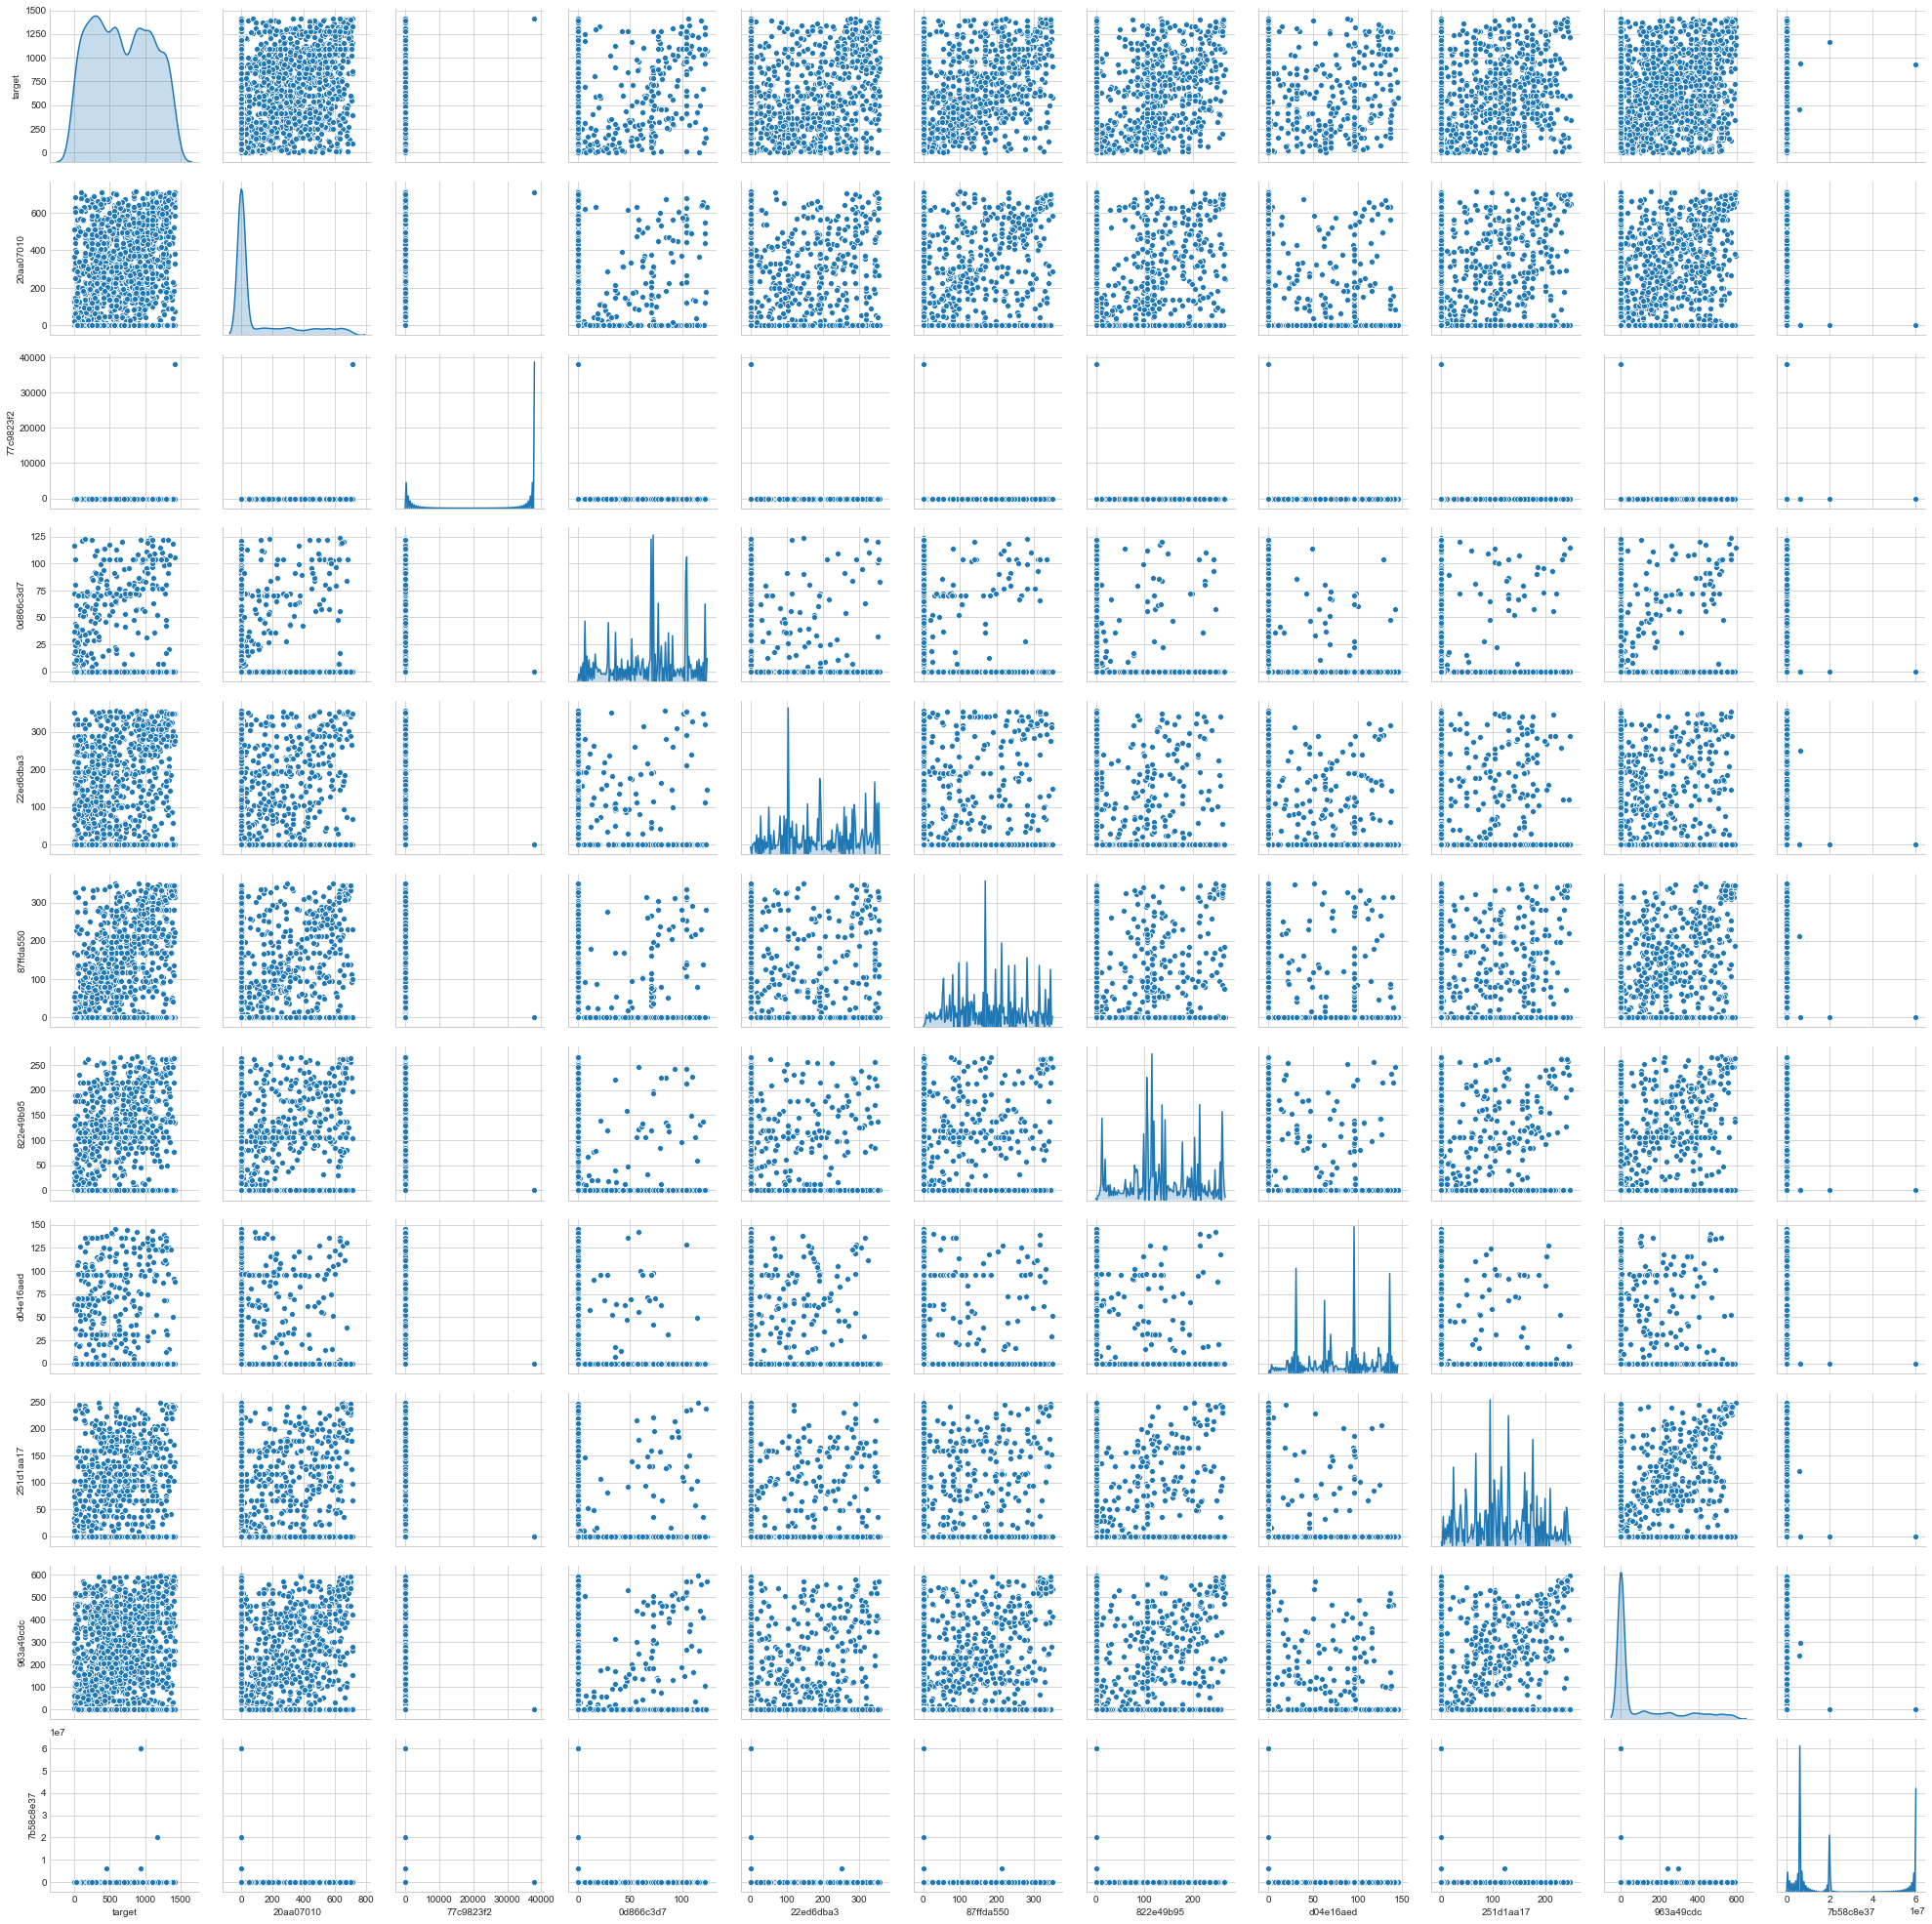

In [47]:
p = sns.pairplot(plt_df, diag_kind="kde", palette="winter")

Even the pairplot of the top ten features gives no clue about a possible correlation between the features and the target. Lets see if the next graph gives us more information:

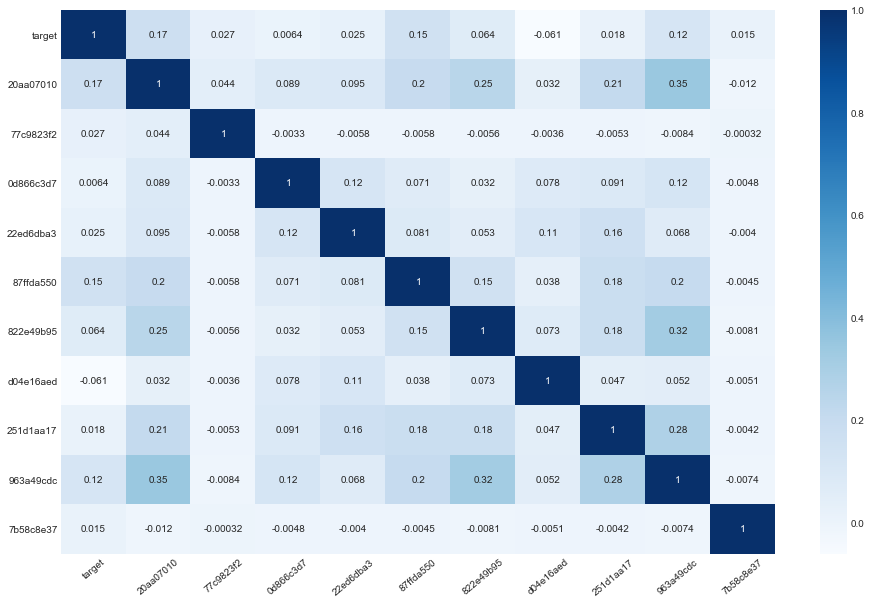

In [55]:
# other way of correlation, to see the actual numbers.
corr = plt_df.corr()
plt.figure(figsize = (16,10))
plt.xticks(fontsize=10,rotation=40)
plt.yticks(fontsize=10,rotation=60)
p =sns.heatmap(corr, annot=True, cmap="Blues")

The nummeric Correlation is validating our picture from the pairplot. Barly correlation, the highest score is 0.17.

Therefore the result of the EDA is we need some good algorithms to predict the target. The Algorithm has to be good in handling 0 values and extracting good networks out of less values (too many 0s) and correlation but on the other side we have many features. The next Notebook will handle that.

In [61]:
plt_df.mean().round(2)

target         673.75
20aa07010      116.84
77c9823f2        8.52
0d866c3d7        3.90
22ed6dba3       32.40
87ffda550       29.84
822e49b95       21.30
d04e16aed        5.20
251d1aa17       17.66
963a49cdc       91.92
7b58c8e37    20679.52
dtype: float64